In [361]:
import pickle
import os
import git
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from nltk.tokenize import TweetTokenizer
from nltk.corpus import wordnet as wn
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
tknzr = TweetTokenizer()

In [187]:
# setup env
import nltk
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/samarthgoal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/samarthgoal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
def get_git_root(path):
    git_repo = git.Repo(path, search_parent_directories=True)
    git_root = git_repo.git.rev_parse("--show-toplevel")
    return git_root

In [189]:
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

In [29]:
def get_tweets_user(df):
    df_tweets_comb = list()
    users = df.userID.unique()
    for user in users:
        tweets =(df.loc[df.userID == user])
        tweets_f = (" . ".join(tweets["tweetText"]))
        df_tweets_comb.append((user,tweets_f))
    df_user = pd.DataFrame(df_tweets_comb, columns=["userID","tweetText"])
    return (df_user)

In [177]:
def clean_text(text):
    text = re.sub(r'(https?://\S+)', "", text) ## remove url
    text = re.sub(r'(\@\w+)', "author",text) ## remove @ mentions with author
    text = re.sub(r'(author)',"",text)     ## remove author
    text = re.sub(r'(#)', "",text)        ## removing the hashtags signal 
    text = re.sub(r'(RT :)', "",text) 
#     text = re.sub(r'(rt :\w+)', "",text)    ## remove the retweet info as they dont convey any information
    text.rstrip 
    text.lstrip
    return(text)

In [185]:
tweet_tknzr = TweetTokenizer()
def prepare_text_LDA(sentence):
#     tokens = nltk.word_tokenize(sentence)  # now using tweet tokenizer
    tokens = tweet_tknzr.tokenize(sentence)
    tokens = [token.lower() for token in tokens if (token not in stopwords and token.isalpha())] # stopwords removal
    tokens = [get_lemma(token) for token in tokens]  # lemmatization
    return (" ".join(tokens))

In [91]:
poly_growth = []
mono_growth = []
years = []
tweets_growth= []

In [17]:
model_dir = os.path.join(get_git_root(os.getcwd()),"models")
poly_dir = os.path.join(model_dir,"poly_users")

In [195]:
poly_users = pickle.load(open(os.path.join(poly_dir,"poly_users.pkl"),"rb"))
normal_users = pickle.load(open(os.path.join(poly_dir,"normal_users.pkl"),"rb"))
juul_before = pickle.load(open(os.path.join(poly_dir,"juul_before.pkl"),"rb"))
df_tweets = pd.read_csv(os.path.join(poly_dir,"labelled_data.csv"),lineterminator="\n")

/home/samarthgoal/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
tweets_all = df_tweets.loc[df_tweets.userID.isin(normal_users)]
tweets_all["tweetCreatedAt"] = pd.to_datetime(tweets_all.tweetCreatedAt)

In [175]:
print("extracting the pattern for weeds")
weed_words = pickle.load(open(os.path.join(model_dir, "weed_words.pkl"), "rb"))
pattern_weed = "|".join(weed_words)

extracting the pattern for weeds


In [358]:
def get_label(df,poly_users):
    label = []
    for idx,row in tweets_user.iterrows():
        if row['userID'] in poly_users:
            label.append("poly")
        else:
            label.append("mono")
    return label

In [156]:
def get_users(df):
    poly_users = []
    mono_users = []
    for idx,row in tweets_user.iterrows():
        if row['userID'] in poly_users:
            poly_users.append(row["userID"])
        else:
            mono_users.append(row["userID"])
    return (mono_users,poly_users)

In [173]:
year_c = [2015,2016,2017,2018,2019]
mono_growth = []
poly_growth = []
total_growth= []
for year in year_c:
    tweets_ = tweets_all[tweets_all.tweetCreatedAt.dt.year < year]
    tweets_user = get_tweets_user(tweets_)
    label = get_label(tweets_user)
    poly_ = len([ele for ele in label if ele == "poly"])
    mono_ = len([ele for ele in label if ele == "mono"])
    print("*****************************************")
    print("poly_users",poly_)
    print("mono_users",mono_)
    print("total_users",poly_ + mono_)
    poly_growth.append(poly_)
    mono_growth.append(mono_)
    total_growth.append(poly_ + mono_)
    tweets_growth.append(len(tweets_))
    years.append(year_c)

*****************************************
poly_users 179
mono_users 30
total_users 209
*****************************************
poly_users 261
mono_users 72
total_users 333
*****************************************
poly_users 361
mono_users 147
total_users 508
*****************************************
poly_users 476
mono_users 439
total_users 915
*****************************************
poly_users 640
mono_users 1878
total_users 2518


In [171]:
years = ["2014-15","2014-16","2014-17","2014-18","2014-19"]

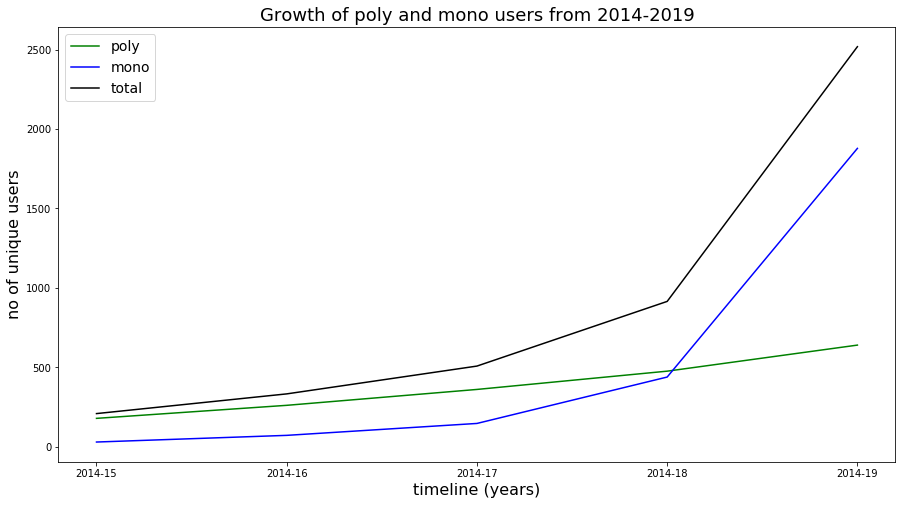

In [172]:
plt.figure(figsize=(15,8))
plt.title("Growth of poly and mono users from 2014-2019",fontsize=18)
plt.xlabel("timeline (years)",fontsize=16)
plt.ylabel("no of unique users",fontsize=16)
plt.plot(years,poly_growth,color="g",label="poly")
plt.plot(years,mono_growth,color="blue",label="mono")
plt.plot(years,total_growth,color="black",label="total")
plt.legend(fontsize=14)
plt.show()

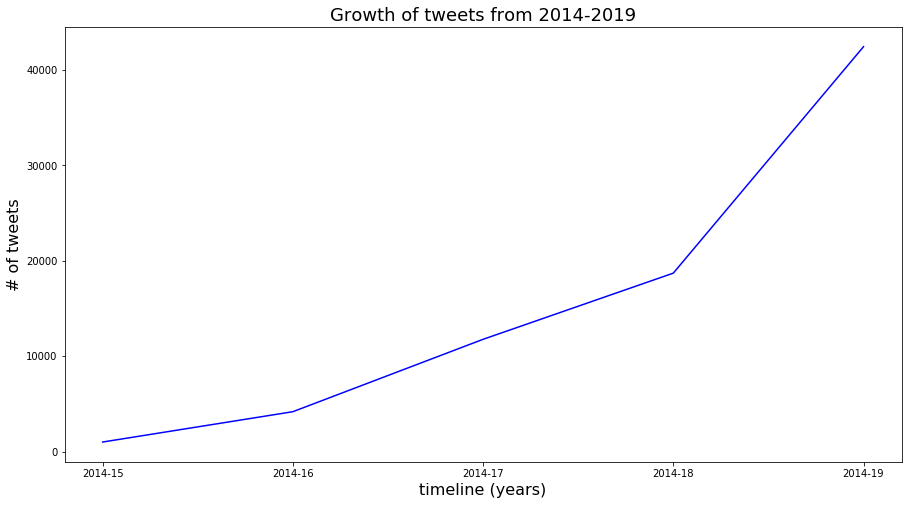

In [145]:
## put this in apendix
plt.figure(figsize=(15,8))
plt.title("Growth of tweets from 2014-2019",fontsize=18)
plt.xlabel("timeline (years)",fontsize=16)
plt.ylabel("# of tweets",fontsize=16)
plt.plot(years,tweets_growth,color="blue")
plt.show()

In [235]:
## finding the escalated users for mono
# escalated = (users(previous_year) - [users(current_year) Ω users(previous_year)])
## assuming no users account are deleted
years_c = [2015,2016,2017,2018,2019]
escalated_growth1 = []
escalated_total = set()
tweets_ = tweets_all[tweets_all.tweetCreatedAt.dt.year < years_c[0]]
tweets_user = get_tweets_user(tweets_)
tweets_user["tweetText"] = tweets_user["tweetText"].apply(clean_text)
tweets_user["tweetText"] = tweets_user["tweetText"].apply(prepare_text_LDA)
total_users = tweets_user.userID.unique()
weed_tweets =  tweets_user[tweets_user["tweetText"].str.contains(pattern_weed)]
weed_users = weed_tweets.userID.unique()
mono_old = list(set(total_users) - set(weed_users))

for year in years_c[1:]:
    tweets_ = tweets_all[tweets_all.tweetCreatedAt.dt.year < year]
    tweets_user = get_tweets_user(tweets_)
    tweets_user["tweetText"] = tweets_user["tweetText"].apply(clean_text)
    tweets_user["tweetText"] = tweets_user["tweetText"].apply(prepare_text_LDA)
    total_users = tweets_user.userID.unique()
    weed_tweets =  tweets_user[tweets_user["tweetText"].str.contains(pattern_weed)]
    weed_users = weed_tweets.userID.unique()
    mono_new = list(set(total_users) - set(weed_users))
    escalated_c = list(set(mono_old) - set(mono_new).intersection(set(mono_old)))
    if not escalated_total:
        escalated_new = escalated_c
    else:
        escalated_new = list(set(escalated_c) - (set(escalated_c).intersection(set(escalated_total))))   
    for user in escalated:
        escalated_total.add(user)
    escalated_growth1.append(len(escalated_new))
    mono_old = mono_new

50
9
11
14
0


In [213]:
years = ["2015","2016","2017","2018"]

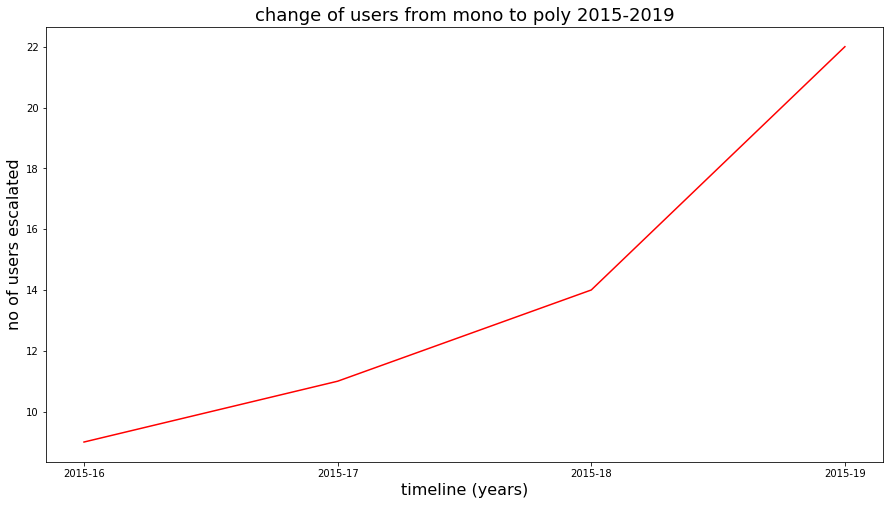

In [209]:
plt.figure(figsize=(15,8))
plt.title("change of users from mono to poly 2015-2019 (cumulative)",fontsize=18)
plt.xlabel("timeline (years)",fontsize=16)
plt.ylabel("no of users escalated",fontsize=16)
plt.plot(years,escalated_growth,color="red")
plt.show()

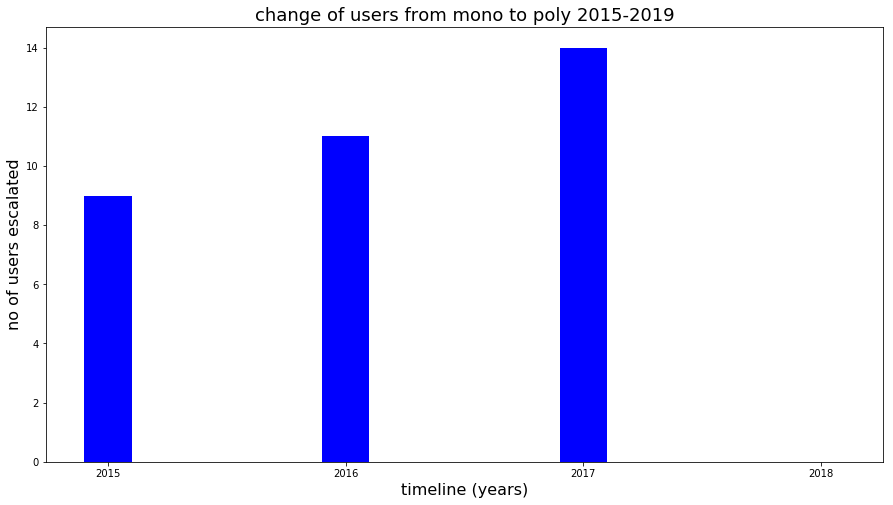

In [241]:
plt.figure(figsize=(15,8))
plt.title("change of users from mono to poly 2015-2019",fontsize=18)
plt.xlabel("timeline (years)",fontsize=16)
plt.ylabel("no of users escalated",fontsize=16)
plt.bar(years,escalated_growth1,color="blue",width=0.2)
plt.show()

In [242]:
## looking at the delay of the change of poly to mono
juul_before_tweets = df_tweets.loc[df_tweets.userID.isin(juul_before)]

In [247]:
pattern_juul = 'juul'

In [248]:
juul_tweets = juul_before_tweets.loc[juul_before_tweets["tweetText"].str.contains(pattern_juul,case=False)]
juul_tweets["tweetCreatedAt"] = pd.to_datetime(juul_tweets["tweetCreatedAt"])

/home/samarthgoal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [249]:
## getting juul_first
poly_first_juul_weed = []
for user in juul_before:
    user_tweets = juul_tweets.loc[juul_tweets.userID == user]
    user_tweets = user_tweets.sort_values(by=["tweetCreatedAt"])
    if (list(user_tweets["tweetCreatedAt"])):
        anchor_juul = list(user_tweets["tweetCreatedAt"])[0]
        poly_first_juul_weed.append([user,anchor_juul])

In [250]:
poly_first_juul_weed = pd.DataFrame(poly_first_juul_weed,columns=["userID","juul_first"])
weed_tweets = juul_before_tweets.loc[juul_before_tweets["tweetText"].str.contains(pattern_weed,case=False)]
weed_first = []

## geetting the weed first 
for user in juul_before:
    user_tweets = weed_tweets.loc[weed_tweets.userID == user]
    user_tweets = user_tweets.sort_values(by=["tweetCreatedAt"])
    if (list(user_tweets["tweetCreatedAt"])):
        anchor_weed = list(user_tweets["tweetCreatedAt"])[0]
        anchor_weed = pd.to_datetime(anchor_weed)
        weed_first.append(anchor_weed)
# adding weed_first to the dataframe
poly_first_juul_weed["weed_first"] = weed_first                                             
poly_first_juul_weed = poly_first_juul_weed.sort_values(by=["juul_first"],ascending=True) ## sorting by juul first

In [251]:
poly_first_juul_weed

,userID,juul_first,weed_first
74,141989041,2015-06-01 19:10:55,2016-01-26 22:14:10
112,20659105,2015-08-04 16:16:53,2016-10-06 01:01:49
3,25687773,2015-09-22 18:46:58,2016-12-11 02:10:13
73,4506167112,2015-12-30 19:37:59,2016-01-25 11:50:12
75,361403072,2016-06-07 15:53:59,2016-06-10 20:28:04
2,706991328630968320,2016-07-10 00:10:29,2016-07-27 20:24:00
76,3456044893,2016-07-10 15:53:11,2016-07-10 15:53:11
0,3393370513,2016-09-24 10:46:19,2016-09-26 00:46:40
1,514092250,2016-09-28 15:00:24,2016-09-28 15:00:24
95,778051861269975040,2016-11-20 06:22:38,2017-01-05 04:50:35


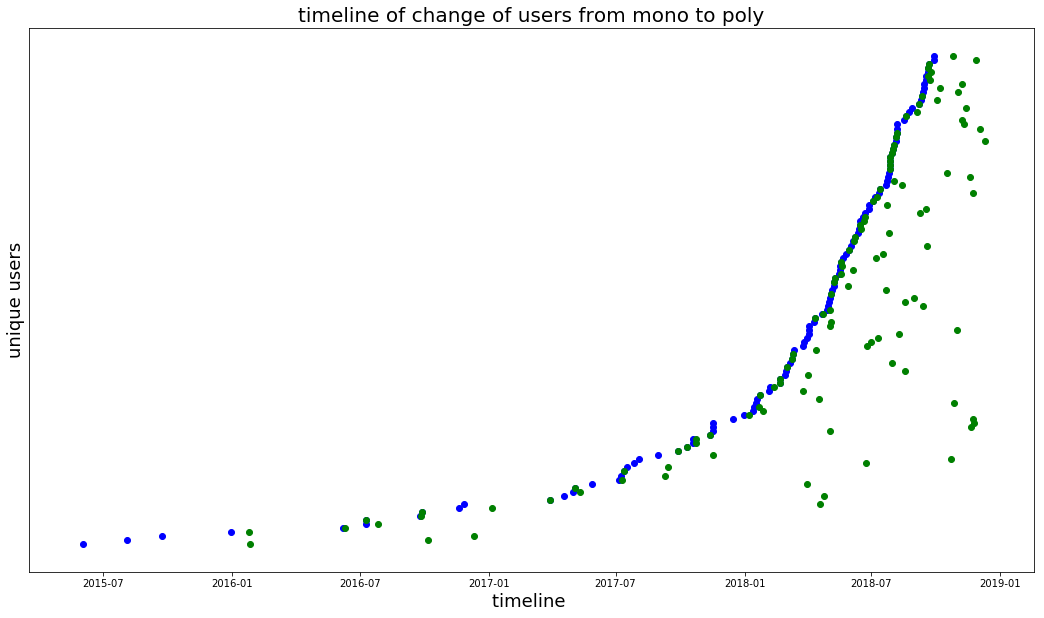

In [380]:
plt.figure(figsize=(18,10))
users_list = list(poly_first_juul_weed.userID.unique())
plt.scatter(list(poly_first_juul_weed["juul_first"]),[str(user) for user in users_list],color="blue")
plt.scatter(list(poly_first_juul_weed["weed_first"]), [str(user) for user in users_list],color="green")
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are of
plt.ylabel("unique users", fontsize = 18)
plt.xlabel("timeline ", fontsize = 18)
plt.title("timeline of change of users from mono to poly" ,fontsize = 20)
plt.show()

In [254]:
poly_first_juul_weed["interval"] = poly_first_juul_weed["weed_first"].dt.date - poly_first_juul_weed["juul_first"].dt.date

In [284]:
days = [(ele).days for ele in list(poly_first_juul_weed["interval"])]
days.sort()

In [320]:
pos = 0
counts = {}
delta = 30
counts[(pos+delta)] = 0
for ele in days:
    if  ele < pos + delta:
        counts[(pos+ delta)] += 1
    else:
        pos += delta
        counts[(pos + delta)] = 1

In [321]:
values = [ele[1] for ele in sorted(counts.items(), key=lambda x: x[0])]
keys = [ele[0] for ele in sorted(counts.items(), key=lambda x: x[0])]
keys = [str(ele) for ele in keys]

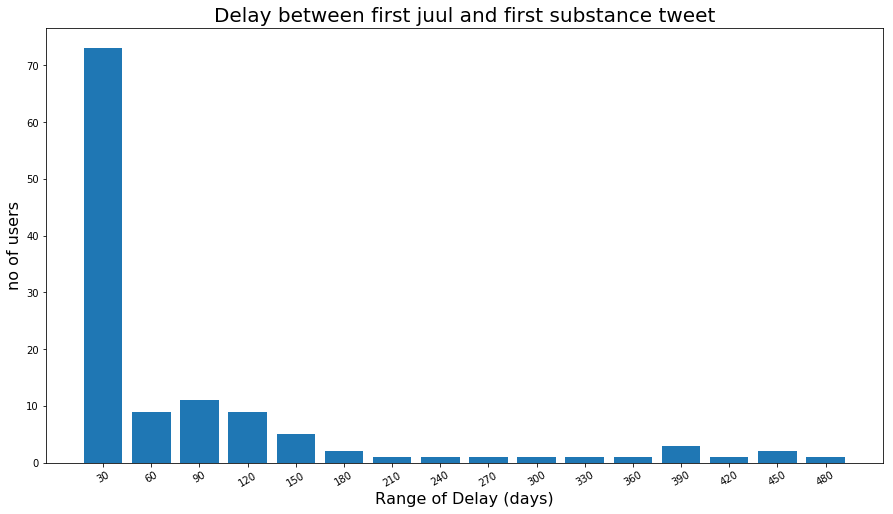

In [326]:
plt.figure(figsize=(15,8))
plt.bar(keys,values)
plt.title("Delay between first juul and first substance tweet",fontsize = 20)
plt.xlabel("Range of Delay (days)",fontsize = 16)
plt.ylabel("no of users",fontsize = 16)
plt.xticks(rotation=30, ha='center')
plt.show()

## looking at the classfier prediction accuarcy for juul before users 

In [329]:
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer as keras_Tokenizer
from sklearn.metrics import classification_report
keras_tkzr = keras_Tokenizer()

Using TensorFlow backend.


In [330]:
def clean_tweets(df):
    df["tweetText"] = df["tweetText"].apply(clean_text)
    df["tweetText"] = df["tweetText"].apply(prepare_text_LDA)
    return (df)

In [332]:
def encode(label):
    le = LabelEncoder()
    le.fit(label)
    y = le.transform(label)
    return y

In [333]:
def get_data(df):
    label = get_label(df)
#     y = encode(label)
    tf_idf = TfidfVectorizer(sublinear_tf=True)
    tf_idf.fit(df["tweetText"])
    feature_names = np.array(tf_idf.get_feature_names())
    X = tf_idf.fit_transform(df["tweetText"])
    print(X.shape)
    return (X,np.array(label),tf_idf)

In [334]:
def svm_wrapper(X_train,Y_train):
    svm = LinearSVC(C=10)
    svm.fit(X_train,Y_train,)
    return svm

In [335]:
tweets_all = df_tweets.loc[df_tweets.userID.isin(normal_users)]

In [337]:
print("total tweets ",len(tweets_all))
print("users", len(tweets_all.userID.unique()))

total tweets  42458
users 2518


In [343]:
tweets_ = clean_tweets(tweets_all)
tweets_user = get_tweets_user(tweets_)  ## combining all of the tweets of the user
X,y,tf_idf_final = get_data(tweets_user)
X_train,X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.25,random_state =4)
svm_final = svm_wrapper(X_train,Y_train)
## svm accuracy on poly mono data ## C=1 kernel= linear
Y_pred = svm_final.predict(X_test)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')

/home/samarthgoal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/samarthgoal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(2518, 29212)
  Classification Report:
               precision    recall  f1-score   support

        mono       0.96      0.99      0.97       459
        poly       0.97      0.88      0.92       171

   micro avg       0.96      0.96      0.96       630
   macro avg       0.96      0.93      0.95       630
weighted avg       0.96      0.96      0.96       630
 



In [352]:
juul_before_tweets = df_tweets.loc[df_tweets.userID.isin(juul_before)]
juul_before_tweets["tweetCreatedAt"] = pd.to_datetime(juul_before_tweets.tweetCreatedAt)

/home/samarthgoal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [353]:
len(tweets_user.userID.unique())

122

In [370]:
years_c = [2015,2016,2017,2018,2019]
f_scores = []
for year in years_c:
    tweets_ = juul_before_tweets[juul_before_tweets.tweetCreatedAt.dt.year < year]
    tweets_ = clean_tweets(tweets_)
    tweets_user = get_tweets_user(tweets_)
    X = tf_idf_final.transform(tweets_user["tweetText"])
    weed_tweets =  tweets_user[tweets_user["tweetText"].str.contains(pattern_weed)]
    poly_users_c = weed_tweets.userID.unique()
    y_true = ["poly" for ele in range(len(tweets_user))]
    y_pred = svm_final.predict(X)
    print('  Classification Report:\n',classification_report(y_true,y_pred),'\n')
    _,_,fscore,_ = precision_recall_fscore_support(y_true,y_pred)
    f_scores.append(fscore[1]) 

/home/samarthgoal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/samarthgoal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


  Classification Report:
               precision    recall  f1-score   support

        mono       0.00      0.00      0.00         0
        poly       0.00      0.00      0.00         2

   micro avg       0.00      0.00      0.00         2
   macro avg       0.00      0.00      0.00         2
weighted avg       0.00      0.00      0.00         2
 

  Classification Report:
               precision    recall  f1-score   support

        mono       0.00      0.00      0.00         0
        poly       1.00      0.12      0.22         8

   micro avg       0.12      0.12      0.12         8
   macro avg       0.50      0.06      0.11         8
weighted avg       1.00      0.12      0.22         8
 

  Classification Report:
               precision    recall  f1-score   support

        mono       0.00      0.00      0.00         0
        poly       1.00      0.67      0.80        15

   micro avg       0.67      0.67      0.67        15
   macro avg       0.50      0.33      0.40   

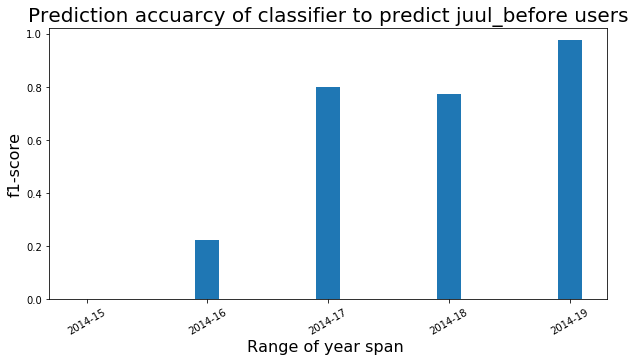

In [378]:
plt.figure(figsize=(10,5))
years = ["2014-15","2014-16","2014-17","2014-18","2014-19"]
plt.bar(years, f_scores,width= 0.2)
plt.title("Prediction accuarcy of classifier to predict juul_before users",fontsize = 20)
plt.xlabel("Range of year span ",fontsize = 16)
plt.ylabel("f1-score",fontsize = 16)
plt.xticks(rotation=30, ha='center')
plt.show()

In [382]:
df_tweets.columns

Index(['favourites_count', 'followersCount', 'friendList', 'friendsCount',
       'hashtags', 'imageurl', 'lang', 'listedCount', 'retweetCount',
       'retweetText', 'retweeted', 'tweetCreatedAt', 'tweetId', 'tweetText',
       'url', 'userCreatedAt', 'userDescription', 'userFollowersCount',
       'userID', 'userLocation', 'userName', 'label'],
      dtype='object')

In [383]:
len(df_tweets)

120470

In [384]:
len(df_tweets.userID.unique())

4857